In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Generate Bering Strait Heat Flux Figure 08

Generates correlation maps of total transport at mooring A3 with zonal winds.  Winds are not rotated.

In [2]:
import pandas as pd
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../source')

from constants import MAP_PROJ, MAP_EXTENT
from constants import MOORING_DIRPATH, REANALYSIS_DIRPATH
import utilities as utils

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl

/home/apbarret/anaconda3/envs/seaicealbedo_update_dask/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/apbarret/anaconda3/envs/seaicealbedo_update_dask/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Read Bearing Strait heat flux and convert to DataArray

In [3]:
heat = utils.read_mooring('TRANSPORT', 'MeanCorr')
heat = heat.dropna()  # Drop NaNs
heat = xr.DataArray.from_series(heat)
heat = heat.rename({'date': 'time'})
heat

<xarray.DataArray 'MeanCorr' (time: 263)>
array([0.6 , 0.62, 1.09, ..., 1.44, 1.45, 1.58])
Coordinates:
  * time     (time) datetime64[ns] 1990-09-01 1990-10-01 ... 2017-06-01

/home/apbarret/anaconda3/envs/seaicealbedo_update_dask/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


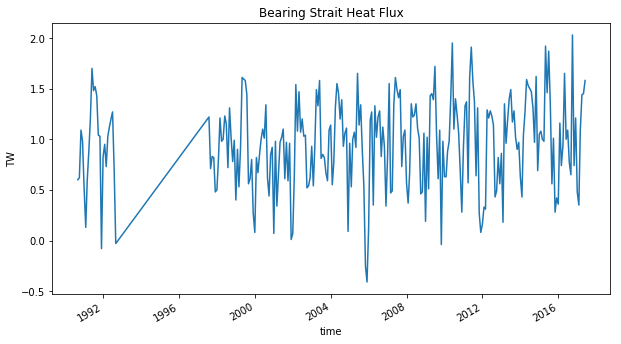

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
heat.plot(ax=ax)
ax.set_title('Bearing Strait Heat Flux')
ax.set_ylabel('TW');

## Get winds

In [5]:
u10m = xr.open_dataset(os.path.join(REANALYSIS_DIRPATH, 'U10M', 'MERRA2_400.instM_2d_asm_Nx.U10M.month.1980to2018.nc4'))
u10m = u10m['U10M'].loc[dict(time=slice('1990-01-01','2017-12-01'), lat=slice(20,90))]

v10m = xr.open_dataset(os.path.join(REANALYSIS_DIRPATH, 'V10M', 'MERRA2_400.instM_2d_asm_Nx.V10M.month.1980to2018.nc4'))
v10m = v10m['V10M'].loc[dict(time=slice('1990-01-01','2017-12-01'), lat=slice(20,90))]

print (u10m)
print (v10m)

<xarray.DataArray 'U10M' (time: 336, lat: 141, lon: 576)>
[27288576 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 20.0 20.5 21.0 21.5 22.0 ... 88.0 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2017-12-01
Attributes:
    long_name:     10-meter_eastward_wind
    units:         m s-1
    vmax:          999999987000000.0
    vmin:          -999999987000000.0
    valid_range:   [-9.99999987e+14  9.99999987e+14]
    origname:      U10M
    fullnamepath:  /U10M
<xarray.DataArray 'V10M' (time: 336, lat: 141, lon: 576)>
[27288576 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 20.0 20.5 21.0 21.5 22.0 ... 88.0 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2017-12-01
Attributes:
    long_name:     10-meter_northward_wind
    units:   

## Calculate correlation coeficient
I haven't figured out how to do this in one fell swoop, so I do it in several steps.
1. Calculate anomaly time series in time dimensions for U10M and heat flux
2. Calculate gridcell covariances between the two data sets
3. Calculate standard deviations for the two data sets
4. Calculate correlation coeficients for each grid cell

### Step 1.  Calculate anomaly time series

In [6]:
def anomaly(x, dim=None):
    return x - x.mean(dim=dim)

In [7]:
heatAnom = heat.groupby('time.month').apply(anomaly)
u10mAnom = u10m.groupby('time.month').apply(anomaly, dim='time')

### Step 2. Calculate covariance

In [8]:
cov = (u10mAnom * heatAnom).groupby('time.month').mean(dim='time')

### Step 3. Calculate standard deviations

In [9]:
heatStd = heat.groupby('time.month').std(dim='time')
u10mStd = u10m.groupby('time.month').std(dim='time')

In [10]:
print (cov.shape)
print (heatStd.shape)
print (u10mStd.shape)

(12, 141, 576)
(12,)
(12, 141, 576)


### Step 4. Calculate correlation coeficient

In [11]:
corrcoef = cov / (heatStd * u10mStd)

In [12]:
from scipy import stats

# calculate t-statistic
n = heat.groupby('time.month').count()
dgf = np.sqrt(n - 2)
den = np.sqrt(1 - (corrcoef*corrcoef))
t = corrcoef*dgf / den

p = 1 - stats.t.cdf(np.abs(t), 21)
r = corrcoef.where(2*p < 0.05)

## Plot results

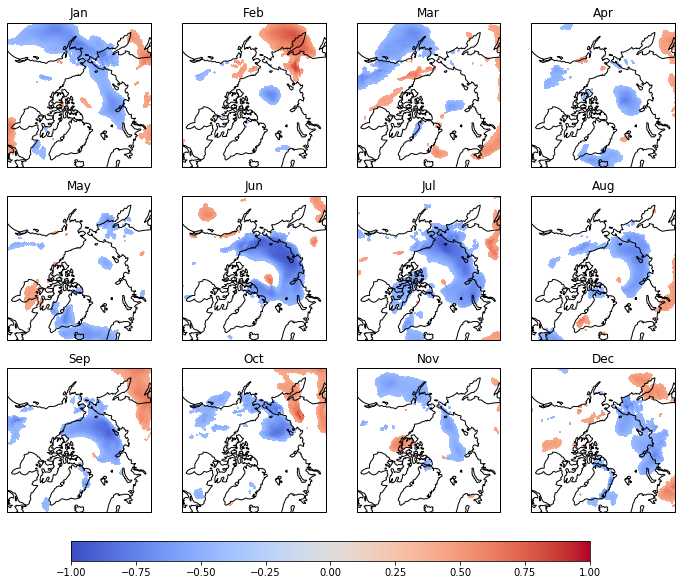

In [14]:
fig = plt.figure(figsize=(12, 9))

land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor=0.5)

cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=-1., vmax=1.)

ax = []
monthstr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i, mstr in enumerate(monthstr):
        
    ax.append( plt.subplot(3, 4, i+1, projection=ccrs.NorthPolarStereo()) )
    
    ax[i].set_extent(MAP_EXTENT, MAP_PROJ)
    cax = r.isel(month=i).plot(ax=ax[i], transform=ccrs.PlateCarree(), add_colorbar=False, 
                               norm=norm, cmap=cmap)
    ax[i].coastlines()
    ax[i].set_title(mstr)

axc = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar = mpl.colorbar.ColorbarBase(axc, orientation='horizontal', norm=norm, cmap=cmap)

fig.savefig(os.path.join('MERRA2_U10M_BSTransport_Correlation_Month.png'))
#ax.add_feature(cfeature.LAND, zorder=1, facecolor=0.3)